In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import tqdm
import utils as utils

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import forward
from src.fair.ancil import get_gas_params, get_thermal_params
from src.preprocessing import load_emissions_dataset, load_response_dataset
from src.models import ThermalBoxesGP
from src.structures import Scenario, ScenarioDataset

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

<IPython.core.display.Javascript object>

In [3]:
train_keys = ['historical', 'ssp126', 'ssp370', 'ssp585']
test_keys = ['ssp245']
keys = train_keys + test_keys
inputs = {key: load_emissions_dataset(f'../data/inputs_{key}.nc') for key in keys}
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in keys}

def make_scenario(name, hist_scenario=None):
    time, _, emission, tas = utils.extract_arrays(inputs[name], outputs[name])
    scenario = Scenario(name=name,
                        timesteps=torch.from_numpy(time).float(),
                        emissions=torch.from_numpy(emission).float().T,
                        tas=torch.from_numpy(tas).float(),
                        hist_scenario=hist_scenario)
    return scenario

In [4]:
hist_scenario = make_scenario('historical')
ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
scenarios = {'historical': hist_scenario}
for name in ssps:
    scenario = make_scenario(name, hist_scenario)
    scenarios[name] = scenario
    
train_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in train_keys]),
                                  hist_scenario=hist_scenario)
test_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in test_keys]),
                                 hist_scenario=hist_scenario)

In [5]:
k1 = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3]))
k2 = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3]))
k3 = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3]))
k2.raw_outputscale = k1.raw_outputscale
k3.raw_outputscale = k1.raw_outputscale
base_kwargs = utils.get_fair_params()
d = base_kwargs['d']
q = base_kwargs['q']

In [6]:
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(scenario_dataset=train_scenarios,
                       kernels=[k1, k2, k3],
                       likelihood=likelihood,
                       q=q, d=d)

In [7]:
# Find optimal model hyperparameters
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 70
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    output = model()
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

Iter:   0%|          | 0/70 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
# torch.save(model.state_dict(), './state_dict.pt')
state_dict = torch.load('./state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
model.kernels[0].outputscale

tensor(0.4196, grad_fn=<SoftplusBackward>)

In [34]:
def get_lengthscales_df(model):
    lengthscales = torch.cat([k.base_kernel.lengthscale.detach() for k in model.kernels])
    data = lengthscales.numpy()
    columns = ['CO2', 'CH4', 'SO2', 'BC']
    index = [1, 2, 3]
    return pd.DataFrame(data=data, columns=columns, index=index).rename_axis('Box')
get_lengthscales_df(model)

,CO2,CH4,SO2,BC
Box,,,,
1,0.018022,0.167485,0.214878,0.140125
2,2.398759,0.682896,1.985844,4.355116
3,0.693147,0.693147,0.693147,0.693147


In [35]:
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

test_tas_fair = model._compute_mean(test_scenarios)

with torch.no_grad():
    test_prior = model.forward(test_scenarios)
    noisy_test_prior = likelihood(test_prior)

prior_mean = noisy_test_prior.mean + test_tas_fair
prior_lb, prior_ub = noisy_test_prior.confidence_region()
prior_lb = prior_lb + test_tas_fair
prior_ub = prior_ub + test_tas_fair

posterior_mean = noisy_pred.mean + test_tas_fair
posterior_lb, posterior_ub = noisy_pred.confidence_region()
posterior_lb = posterior_lb + test_tas_fair
posterior_ub = posterior_ub + test_tas_fair

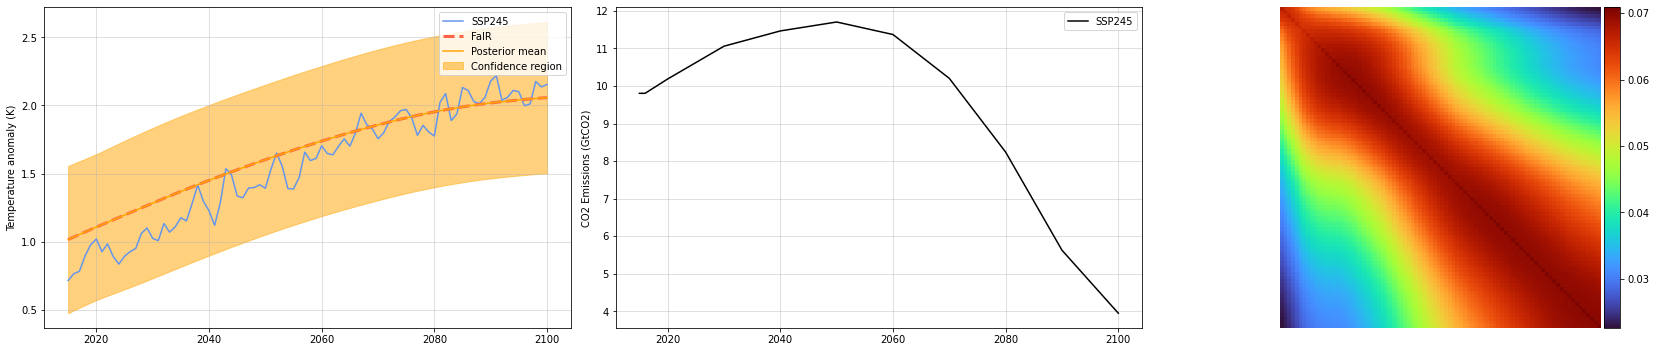

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))


ax[0].plot(test_times, test_tas, color='cornflowerblue', label='SSP245')
ax[0].set_ylabel('Temperature anomaly (K)')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=3, label='FaIR')
ax[0].plot(test_times, prior_mean, color='orange', label='Posterior mean')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.5, color='orange', label='Confidence region')
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].plot(test_times, test_scenarios.emissions[:, 0], label='GtCO2/yr', color='k')
ax[1].set_ylabel('CO2 Emissions (GtCO2)')
ax[1].grid(alpha=0.5)
ax[1].legend()

im = ax[2].imshow(test_prior.covariance_matrix, cmap='turbo')
colorbar(im)
ax[2].axis('off')

plt.tight_layout()
plt.show()

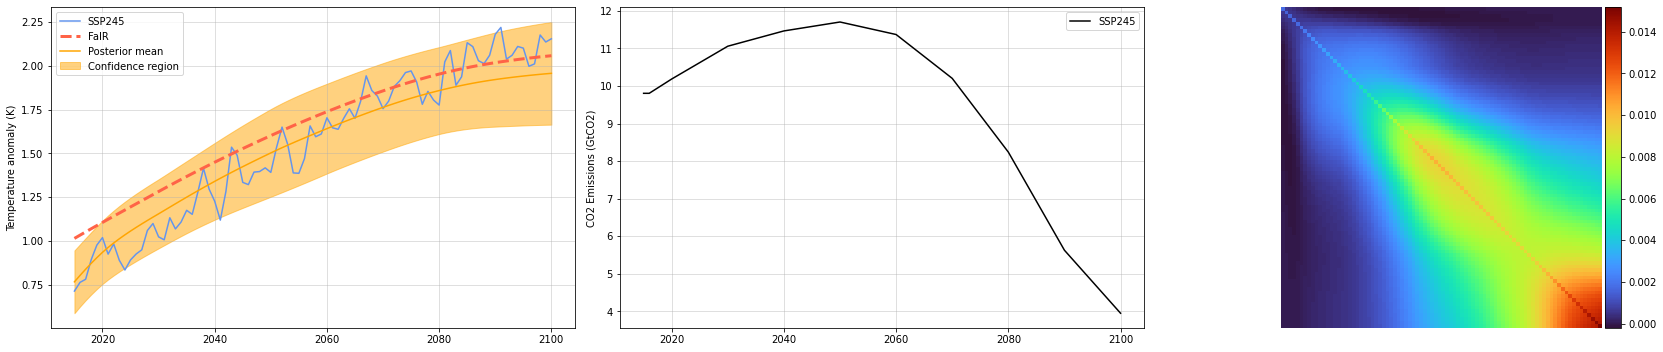

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))

ax[0].plot(test_times, test_tas, color='cornflowerblue', label='SSP245')
ax[0].set_ylabel('Temperature anomaly (K)')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=3, label='FaIR')
ax[0].plot(test_times, posterior_mean, color='orange', label='Posterior mean')
ax[0].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.5, color='orange', label='Confidence region')
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].plot(test_times, test_scenarios.emissions[:, 0], label='GtCO2/yr', color='k')
ax[1].set_ylabel('CO2 Emissions (GtCO2)')
ax[1].grid(alpha=0.5)
ax[1].legend()


im = ax[2].imshow(pred.covariance_matrix, cmap='turbo')
colorbar(im)
ax[2].axis('off')

plt.tight_layout()
plt.show()

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/torch/distributions/distribution.py:151: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


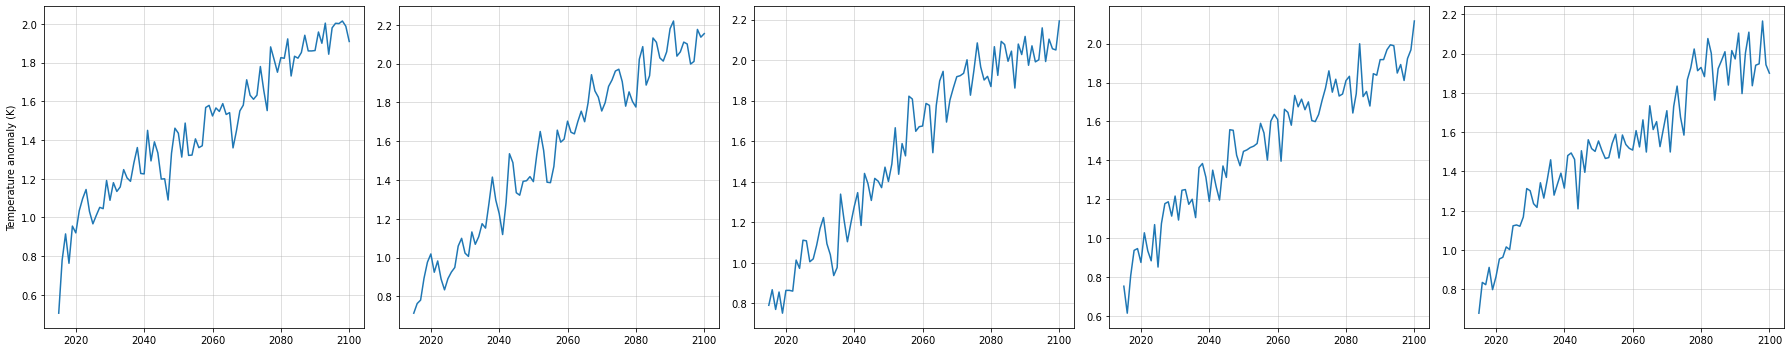

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
draws = noisy_pred.sample_n(5)
draws = draws + test_tas_fair
rdm_idx = torch.randperm(5)
for i in rdm_idx[:-1]:
    ax[i].plot(test_times, draws[i])
    ax[i].grid(alpha=0.5)
ax[rdm_idx[-1]].plot(test_times, test_tas)
ax[rdm_idx[-1]].grid(alpha=0.5)
ax[0].set_ylabel('Temperature anomaly (K)')
plt.tight_layout()
plt.show()

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/torch/distributions/distribution.py:151: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


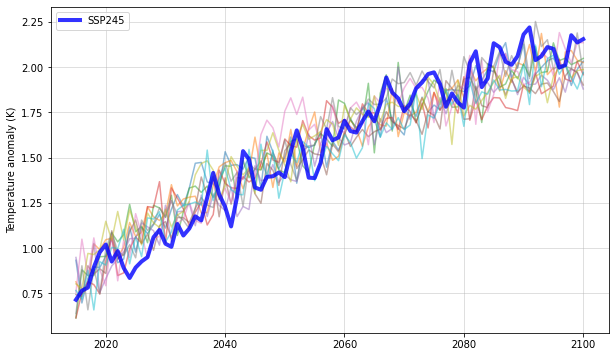

In [23]:
torch.random.manual_seed(5)
draws = noisy_pred.sample_n(10)
draws = draws + test_tas_fair

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_ylabel('Temperature anomaly (K)')
for draw in draws:
    ax.plot(test_times, draw, alpha=0.5)
ax.plot(test_times, test_tas, color='blue', label='SSP245', lw=4, alpha=0.8)
ax.grid(alpha=0.5)
plt.legend()
plt.show()